# Mapping mining areas

This notebook shows how to map mining areas using the Segment Anything Model (SAM). 

To speed up the process, use GPU runtime for this notebook. 

## Install dependencies

Uncomment and run the following cell to install the required dependencies.

In [ ]:
# installing directly from GitHub to most recent updates
# This solved the issue of opencv-library 
# %pip install git+https://github.com/opengeos/segment-geospatial # @v0.10.5


In [ ]:
# %pip install groundingdino-py localtileserver jupyter-server-proxy

In [1]:
import leafmap
from samgeo import SamGeo, tms_to_geotiff, get_basemaps
from samgeo.text_sam import LangSAM

import sys
sys.path.append('..')
from src.get_sentinel_images import ReadSTAC

Check if GPU is available

In [2]:
import torch
torch.cuda.is_available()

False

## Create an interactive map

In [3]:
m = leafmap.Map(center=[-6.054643555224412, -50.18255000697929], zoom=12, height="600px")
m.add_basemap("satellite")
m

Map(center=[-6.054643555224412, -50.18255000697929], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Download a sample image

Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map

In [11]:
bbox = m.user_roi_bounds()
bbox

In [ ]:
# image = "Image.tif"
# tms_to_geotiff(output=image, bbox=bbox, zoom=12, source="Satellite", overwrite=True)

You can also use your own image. Uncomment and run the following cell to use your own image.

In [4]:
# Option 2: Read from AWS STAC API
api_url="https://earth-search.aws.element84.com/v1"
bands = ['red', 'green', 'blue']

stac_reader = ReadSTAC(api_url=api_url)

# check available items
items = stac_reader.get_items(
    location = [-50.18255000697929, -6.054643555224412],
    buffer=10,
    timerange='2021-04-01/2021-06-30',
    max_cloud_cover=10
)

stack = stac_reader.get_stack(items, filter_by="least_cloudy", bands=bands, resolution=10)
stack_stretched = stac_reader.stretch_contrast_stack(stack)
image = stac_reader.save_stack_as_geotiff(stack_stretched)

8 Items found.
Loading stack...
Choosing S2A_22MEU_20210629_0_L2A from 2021-06-29 with 0.007832% cloud cover
Stretching contrast...
Saving stack as GeoTIFF under: /workspaces/mine-segmentation/src/data/temp/S2A_22MEU_20210629_0_L2A.tif


Display the downloaded image on the map.

In [5]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(bottom=542256.0, center=[-6.054643555224412, -50.18255000697929], controls=(ZoomControl(options=['position…

## Initialize SAM class

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

In [ ]:
sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=None,
)

## Automatic mask generation

Segment the image and save the results to a GeoTIFF file. Set `unique=True` to assign a unique ID to each object. 

In [ ]:
sam.generate(image, output="data/masks.tif", foreground=True, unique=True)

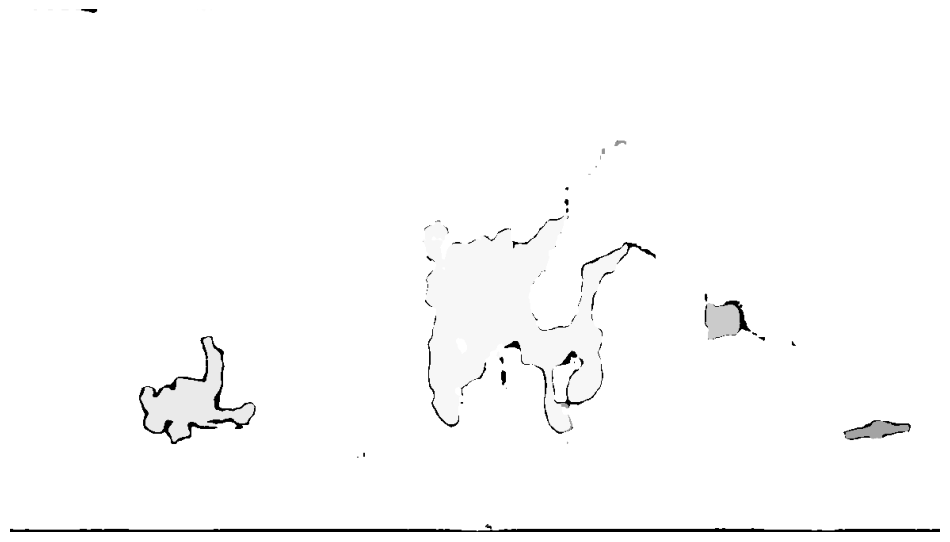

In [ ]:
sam.show_masks(cmap="binary_r")

## Initialize LangSAM class

The initialization of the LangSAM class might take a few minutes. The initialization downloads the model weights and sets up the model for inference.

In [14]:
sam = LangSAM()

final text_encoder_type: bert-base-uncased


groundingdino_swinb_cogcoor.pth:   9%|8         | 83.9M/938M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
 72%|███████▏  | 1.73G/2.39G [09:56<03:47, 3.11MB/s]  


KeyboardInterrupt: 

## Specify text prompts

In [ ]:
text_prompt = "mining area"

## Segment the image

Part of the model prediction includes setting appropriate thresholds for object detection and text association with the detected objects. These threshold values range from 0 to 1 and are set while calling the predict method of the LangSAM class.

`box_threshold`: This value is used for object detection in the image. A higher value makes the model more selective, identifying only the most confident object instances, leading to fewer overall detections. A lower value, conversely, makes the model more tolerant, leading to increased detections, including potentially less confident ones.

`text_threshold`: This value is used to associate the detected objects with the provided text prompt. A higher value requires a stronger association between the object and the text prompt, leading to more precise but potentially fewer associations. A lower value allows for looser associations, which could increase the number of associations but also introduce less precise matches.

Remember to test different threshold values on your specific data. The optimal threshold can vary depending on the quality and nature of your images, as well as the specificity of your text prompts. Make sure to choose a balance that suits your requirements, whether that's precision or recall.

In [ ]:
sam.predict(image, text_prompt, box_threshold=0.3, text_threshold=0.5)

## Visualize the results

Show the result with bounding boxes on the map.

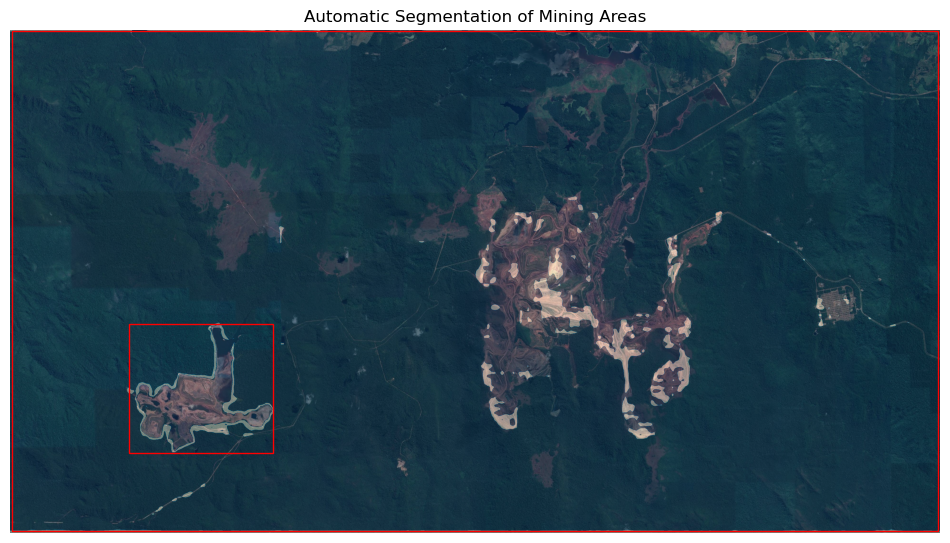

In [ ]:
sam.show_anns(
    cmap="Blues",
    box_color="red",
    title="Automatic Segmentation of Mining Areas",
    blend=True,
)

Show the result without bounding boxes on the map.

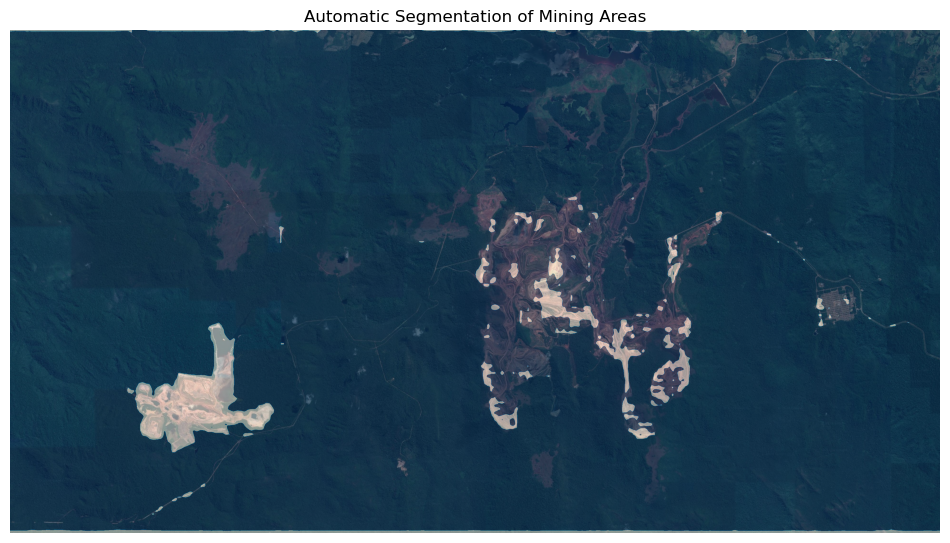

In [ ]:
sam.show_anns(
    cmap="Blues",
    add_boxes=False,
    alpha=0.5,
    title="Automatic Segmentation of Mining Areas",
)

Show the result as a grayscale image.

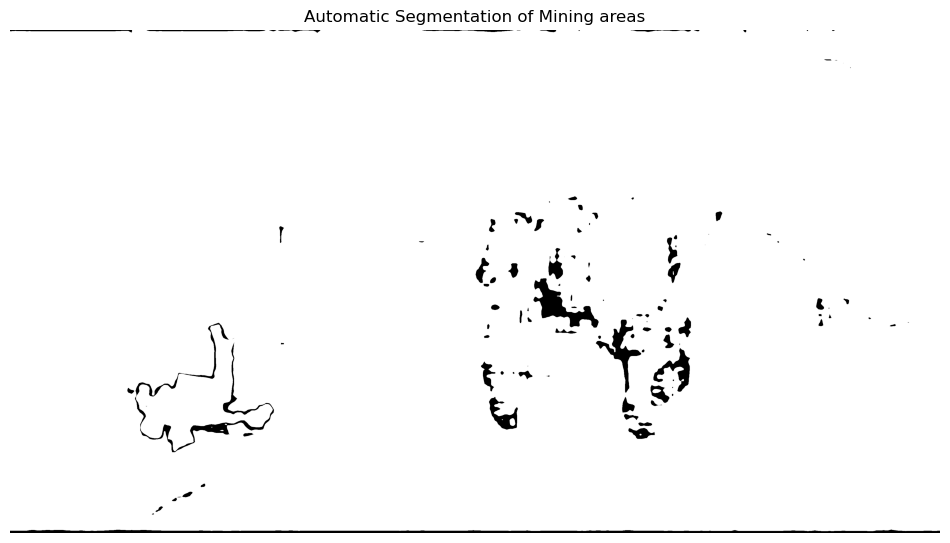

In [74]:
sam.show_anns(
    cmap="Greys_r",
    add_boxes=False,
    alpha=1,
    title="Automatic Segmentation of Mining areas",
    blend=False,
    output="minearea.tif",
)

Convert the result to a vector format.  

In [75]:
sam.raster_to_vector("minearea.tif", "minearea.shp")

Show the results on the interactive map.

In [76]:
m.add_raster("minearea.tif", layer_name="minearea", palette="Blues", opacity=0.5, nodata=0)
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector("minearea.shp", layer_name="Vector", style=style)
m

Map(bottom=542277.0, center=[-6.0617, -50.19845], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

## Interactive segmentation

In [77]:
sam.show_map()

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…